
# ARO - predicting target based on sensoric data

Author: Sergej Schweizer

12.10.2021

---

## TOC:

# 1. Install packages

In [1]:
#!pip install statsmodels mlxtend tensorflow_data_validation tensorflow xlrd seaborn

# 2. Import
---

In [2]:
import pandas as pd
import numpy as np

import re
from typing import AnyStr, Callable, Tuple

import seaborn as sns 
import matplotlib.pyplot as plt
import datetime
import xlrd
import itertools

import tensorflow as tf
import tensorflow_data_validation as tfdv

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, StandardScaler, KBinsDiscretizer
from sklearn.feature_selection import RFE, SelectKBest, SelectFromModel, chi2, f_classif

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

import statsmodels.api as sm

# 3. Load
---

In [3]:
!head md_target_dataset.csv

index;groups;target
1;0;1.233766234
2;0;2.467532468
3;0;3.701298701
4;0;4.935064935
5;0;6.168831169
6;0;7.402597403
7;0;8.636363636
8;0;9.87012987
9;0;11.1038961


In [4]:
df_raw_predictors = pd.read_csv(
    'md_raw_dataset.csv',
    sep=';',
    #index_col='Unnamed: 0'  # we  will need this column as
)
df_raw_predictors.rename({'Unnamed: 0': 'index_predictors'}, axis=1, inplace=True)

df_raw_target = pd.read_csv(
    'md_target_dataset.csv',
    sep=';',
    index_col='index',
    #usecols=['index','target'],
)
df_raw_predictors.shape, df_raw_target.shape

((9592, 35), (9589, 2))

In [5]:
df_raw_predictors.head(5)

,index_predictors,when,super_hero_group,tracking,place,tracking_times,crystal_type,Unnamed: 7,human_behavior_report,human_measure,...,subprocess1_end,reported_on_tower,opened,chemical_x,raw_kryptonite,argon,pure_seastone,crystal_supergroup,Cycle,groups
0,0,09/07/2020,D,84921,1,1,group 27,2,3,650,...,09/07/2020 13:27,09/07/2020 13:37,44021.58091,15.850000,693.0,0.0,49.51,0,2ª,0.0
1,1,09/07/2020,D,84941,1,1,group 56,1,4,700,...,09/07/2020 15:38,09/07/2020 15:53,44021.6737,21.966667,3570.0,0.0,99.94,0,2ª,0.0
2,2,09/07/2020,D,84951,1,1,group 56,2,4,800,...,09/07/2020 16:41,09/07/2020 16:54,44021.70867,21.166667,7950.0,0.0,91.49,0,2ª,0.0
3,3,09/07/2020,D,84971,1,1,group 56,7,3,700,...,09/07/2020 18:47,09/07/2020 18:55,09/07/2020 19:02,15.250000,807.0,0.0,NaN,0,2ª,0.0
4,4,09/07/2020,D,84981,1,1,group 27,17,3,700,...,09/07/2020 19:37,09/07/2020 19:47,09/07/2020 20:20,20.566667,NaN,0.0,509.19,0,2ª,0.0


# 4. EDA

In [47]:
# Generate dataset statistics
comb_stats = tfdv.generate_statistics_from_dataframe(df_raw_predictors)
# Compare training with evaluation
tfdv.visualize_statistics(comb_stats)

In [46]:
# Generate dataset statistics
comb_stats = tfdv.generate_statistics_from_dataframe(df_raw_target)
# Compare training with evaluation
tfdv.visualize_statistics(comb_stats)

# 5. Conclusions

* 1. groups columns in predictors and target dataframes seems to be similar, therefore we can try to map target to predictors
* 2. etherium_before_start has nearly 79% of missing values (NaN), this column can be deleted
* 3. multiple date columns has missing values, can we do imputation ? (mean, average ?)


In [8]:
# Also we know now what kind of data we have !!!
DATE_COLUMNS = ['when', 'expected_start', 'start_process', 'start_subprocess1', 
                'start_critical_subprocess1','predicted_process_end',
                'process_end','subprocess1_end','reported_on_tower','opened']

CATEGORICAL_COLUMS = ['super_hero_group','crystal_type', 'crystal_supergroup', 'Cycle']


NUMERICAL_COLUMNS = [
    'tracking','place','tracking_times','Unnamed: 7','human_behavior_report', 'human_measure',
    'crystal_weight', 'expected_factor_x', 'previous_factor_x', 'first_factor_x',
    'expected_final_factor_x', 'final_factor_x', 'previous_adamantium', 'Unnamed: 17', 
    'chemical_x', 'raw_kryptonite', 'argon', 'pure_seastone' , 'groups', 'index_predictors']

ABSOLETE_COLUMNS = ['etherium_before_start']

TARGET_COLUMN = ['target']

# 6. Merge target with predictors
---

Groups within predictors and target seems to have same structure, only the groupid is different.

In [9]:
def merge_based_on_group_occurences(df1: pd.DataFrame, df2: pd.DataFrame)-> pd.DataFrame:
    '''
    merge group ids to each other based on number of occurences
    '''
    
    # map group ids according to occurences
    df_temp = pd.merge(
        df1['groups'].value_counts().to_frame('occurences').reset_index(),
        df2['groups'].value_counts().to_frame('occurences').reset_index(),
        suffixes=('_predictor','_target'),
        on='occurences',
        how='inner'

    )
    
    df_temp.columns = ['group_id_predictors', 'occurences', 'group_id_target']
    return df_temp

df_groups = merge_based_on_group_occurences(
    df_raw_predictors,
    df_raw_target
)

df_groups.sort_values('group_id_predictors').head(10)

,group_id_predictors,occurences,group_id_target
6,0.0,154,0
14,1.0,149,37
13,1.0,149,1
12,1.0,149,45
35,2.0,144,39
36,2.0,144,34
37,2.0,144,8
150,3.0,81,40
144,4.0,103,41
133,5.0,114,30


We just need to find most nearest group_id with respect to occurences

In [10]:
def filter_group_ids_based_distance(df_groups: pd.DataFrame)-> pd.DataFrame:
    '''
    In case we have multiple target group ids,  find the closest one
    Assumption: same/similiar group ids = same groups in both dataframes
    '''
   
    df_groups_filterd = pd.DataFrame()

    for _, df_temp in df_groups.groupby('group_id_predictors'):
        idx = df_temp.iloc[0,0]
        ocs = df_temp.iloc[0,1]
        idx_target = df_groups.iloc[df_temp['group_id_target'].sub(idx).abs().idxmin()]['group_id_target']

        # build new dataframe with filtered group ids
        df_groups_filterd = df_groups_filterd.append(
            {'group_id_predictors': idx,
             'occurences': ocs,
             'group_id_target':idx_target},
            ignore_index=True).astype(int)

    return df_groups_filterd

df_groups_filter = filter_group_ids_based_distance(df_groups)
df_groups_filter.head(10)

,group_id_predictors,group_id_target,occurences
0,0,0,154
1,1,1,149
2,2,8,144
3,3,40,81
4,4,41,103
5,5,30,114
6,6,2,112
7,7,32,128
8,8,12,134
9,9,3,133


Now we concat (axis=1) predictors with target

In [11]:
def concat_predictors_and_target(
    df_groups: pd.DataFrame, 
    df_predictors: pd.DataFrame, 
    df_target: pd.DataFrame)-> pd.DataFrame:
    '''
    concat predictors and target according to groups mapping
    '''

    df = pd.DataFrame()

    for idx, row in df_groups.iterrows():
        df = df.append(pd.concat(
            [
                df_predictors[df_predictors['groups'] == row['group_id_predictors']].reset_index(drop=True),
                df_target[df_target['groups'] == row['group_id_target']]['target'].reset_index(drop=True),
            ],
            ignore_index=True,
            axis=1,
            )
        )
    df.columns = df_predictors.columns.tolist() + ['target']
    
    return df



df = concat_predictors_and_target(
    df_groups_filter,
    df_raw_predictors,
    df_raw_target
)
df

,index_predictors,when,super_hero_group,tracking,place,tracking_times,crystal_type,Unnamed: 7,human_behavior_report,human_measure,...,reported_on_tower,opened,chemical_x,raw_kryptonite,argon,pure_seastone,crystal_supergroup,Cycle,groups,target
0,0,09/07/2020,D,84921,1,1,group 27,2,3,650,...,09/07/2020 13:37,44021.58091,15.850000,693.0,0.000000,49.51,0,2ª,0.0,1.233766
1,1,09/07/2020,D,84941,1,1,group 56,1,4,700,...,09/07/2020 15:53,44021.6737,21.966667,3570.0,0.000000,99.94,0,2ª,0.0,2.467532
2,2,09/07/2020,D,84951,1,1,group 56,2,4,800,...,09/07/2020 16:54,44021.70867,21.166667,7950.0,0.000000,91.49,0,2ª,0.0,3.701299
3,3,09/07/2020,D,84971,1,1,group 56,7,3,700,...,09/07/2020 18:55,09/07/2020 19:02,15.250000,807.0,0.000000,NaN,0,2ª,0.0,4.935065
4,4,09/07/2020,D,84981,1,1,group 27,17,3,700,...,09/07/2020 19:47,09/07/2020 20:20,20.566667,NaN,0.000000,509.19,0,2ª,0.0,6.168831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,131,27/03/2021,A,133831,1,1,group 22,9,3,690,...,27/03/2021 21:39,27/03/2021 21:59,25.900000,NaN,0.000000,88.61,0,1ª,77.0,223.235294
132,132,28/03/2021,A,133841,1,2,group 7,20,3,480,...,28/03/2021 00:56,28/03/2021 01:03,37.166667,NaN,302.248697,486.79,0,1ª,77.0,224.926471
133,133,28/03/2021,B,133941,1,1,group 80,1,1,600,...,28/03/2021 14:18,28/03/2021 14:33,39.283333,NaN,787.991333,741.17,0,1ª,77.0,226.617647
134,134,28/03/2021,B,133981,1,1,group 5,14,2,500,...,28/03/2021 18:44,28/03/2021 18:56,44.216667,NaN,395.447094,1115.60,0,1ª,77.0,228.308823


# 7. Exprolative Data Analyis
---
We begin our EDA with the target variable, key insights we should gain:
* what kind of distribution is it
* how many "mechanisms" have influence on the target variable (how many distributions)

<AxesSubplot:xlabel='index_predictors', ylabel='target'>

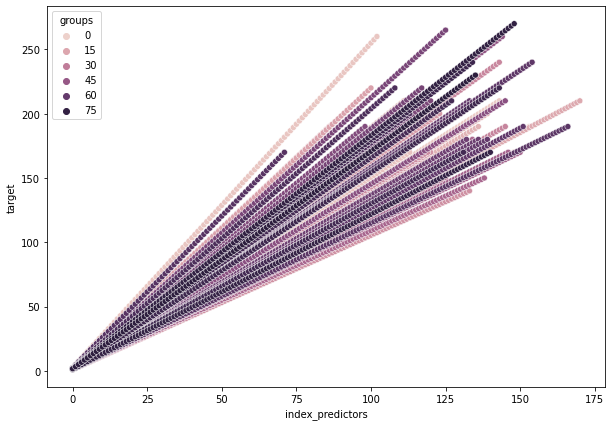

In [12]:
ax = plt.subplots(figsize=(10,7))
sns.scatterplot(
    x='index_predictors',
    y='target',
    data=df,
    hue='groups',   
)

* We have multiple linear relations of target and index (former "unknown: 0") of the predictors (< 175)
* Intercept is always zero
* coeficients may differ regardless to the groups variable
* Our task is to predict the target variable, !!!
* We need to find variables which explain the slope of linear regression

## 7.1 Analyze predictors
---

We begin with date columns


In [13]:
df[DATE_COLUMNS]

,when,expected_start,start_process,start_subprocess1,start_critical_subprocess1,predicted_process_end,process_end,subprocess1_end,reported_on_tower,opened
0,09/07/2020,09/07/2020 13:10,09/07/2020 13:08,09/07/2020 13:11,09/07/2020 13:13,09/07/2020 13:41,09/07/2020 13:28,09/07/2020 13:27,09/07/2020 13:37,44021.58091
1,09/07/2020,09/07/2020 15:08,09/07/2020 15:11,09/07/2020 15:16,09/07/2020 15:18,09/07/2020 15:49,09/07/2020 15:39,09/07/2020 15:38,09/07/2020 15:53,44021.6737
2,09/07/2020,09/07/2020 16:15,09/07/2020 16:16,09/07/2020 16:20,09/07/2020 16:22,09/07/2020 16:54,09/07/2020 16:42,09/07/2020 16:41,09/07/2020 16:54,44021.70867
3,09/07/2020,09/07/2020 18:22,09/07/2020 18:24,09/07/2020 18:31,09/07/2020 18:33,09/07/2020 19:02,09/07/2020 18:47,09/07/2020 18:47,09/07/2020 18:55,09/07/2020 19:02
4,09/07/2020,09/07/2020 19:14,09/07/2020 19:12,09/07/2020 19:16,NaN,09/07/2020 20:13,09/07/2020 19:37,09/07/2020 19:37,09/07/2020 19:47,09/07/2020 20:20
...,...,...,...,...,...,...,...,...,...,...
131,27/03/2021,27/03/2021 20:45,27/03/2021 20:57,27/03/2021 21:02,27/03/2021 21:15,27/03/2021 21:11,27/03/2021 21:28,27/03/2021 21:27,27/03/2021 21:39,27/03/2021 21:59
132,28/03/2021,27/03/2021 22:20,28/03/2021 00:02,28/03/2021 00:10,NaN,28/03/2021 01:00,28/03/2021 00:47,28/03/2021 00:47,28/03/2021 00:56,28/03/2021 01:03
133,28/03/2021,28/03/2021 13:30,28/03/2021 13:25,28/03/2021 13:29,28/03/2021 13:58,28/03/2021 14:13,28/03/2021 14:09,28/03/2021 14:09,28/03/2021 14:18,28/03/2021 14:33
134,28/03/2021,28/03/2021 17:29,28/03/2021 17:41,28/03/2021 17:45,NaN,28/03/2021 18:27,28/03/2021 18:30,28/03/2021 18:29,28/03/2021 18:44,28/03/2021 18:56


* We have Nans, different date formats (this can be seen also from visualize_statistics)
* Therefore we create helper functions (they should be moved to helper.py) for formating these coluns to generic datetime value (and type)

In [14]:
# Functions for timestamp formating

def exel_timestamp_to_datetime(value: str)-> str:
    '''
    format exel timestamp to datetime str representations
    '''
    
    if re.match(r'\d.\d', str(value)):
        return xlrd.xldate_as_datetime(float(value), 0).strftime('%Y-%m-%d %H:%M:%S')
    else:
        return value

    
def wrong_timestamp_to_datetime(value: str)-> str:
    '''
    format wrong timestamp to datetime str representations
    '''
    
    if re.match(r'\d{2}/\d{2}/\d{4} \d{2}:\d{2}', str(value)):
        #print('bla')
        return datetime.datetime.strptime(value, '%y/%m/%Y %H:%M').strftime('%Y-%m-%d %H:%M:%S')
    else:
        return value

def date_to_datetime(value: str)-> str:
    '''
    format date to datetime str representations
    '''
    #print(value)
    if re.match(r'^\d{2}/\d{2}/\d{4}$', str(value)):
        return datetime.datetime.strptime(value, '%y/%m/%Y').strftime('%Y-%m-%d 00:00')
    else:
        return value

def convert_to_posix_timestamp(x):
    """Convert date objects to integers"""
    return x.timestamp()

### 7.1.1 Format date columns
---

In [15]:
def format_date_columns(df :pd.DataFrame, date_columns: list)-> pd.DataFrame:
    '''
    format date columns
    '''

    df_formated = pd.DataFrame()

    for col in date_columns:
        # format data to same format
        df_formated[col] = df[col].apply(lambda x: exel_timestamp_to_datetime(x))
        df_formated[col] = df[col].apply(lambda x: wrong_timestamp_to_datetime(x))
        df_formated[col] = df[col].apply(lambda x: date_to_datetime(x))

        # format to datetime type
        df_formated[col] = pd.to_datetime(df_formated[col], errors='coerce')

        # fill all nans with columns medians
        df_formated[col].fillna(df_formated[col].median(), inplace=True)
        
    return df_formated

### 7.1.2 Generate new features based on date columns
---

In [16]:
def generate_new_date_features(df: pd.DataFrame, date_columns: list)-> pd.DataFrame:
    '''
    generate new data features
    '''
    
    for col in date_columns:
        # split date to different columns
        df[col+'_year'] = df[col].dt.year
        df[col+'_month'] = df[col].dt.month
        #df_formated[col+'_week'] = df_formated[col].dt.week
        df[col+'_day'] = df[col].dt.dayofyear

        # get hour
        if not col == 'when':
            df[col+'_hour'] = df[col].dt.hour
            # get hour
            df[col+'_minutes'] = df[col].dt.minute
        
    return df_formated
    
def generate_new_diff_fieatures(df: pd.DataFrame, date_columns: list)-> pd.DataFrame:
    '''
    generate new features based on date difference
    
    '''

    combination_of_date_columns = list(itertools.combinations(date_columns, 2))

    # compute differences in minutes between ALL datetime columns
    for col1, col2 in combination_of_date_columns:
        column_name = f"{col1}_diff_{col2}" 
        df[column_name] = (df[col1] - df[col2]).astype('<m8[m]').astype(int)
        
    return df


    
def delete_date_columns(df: pd.DataFrame, date_columns : list)-> pd.DataFrame:
    '''
    delete absolte date columns
    '''
    
    df.drop(date_columns, axis=1, inplace=True)
    return df
    

In [17]:
df_formated = format_date_columns(df, DATE_COLUMNS)
df_formated = generate_new_date_features(df_formated, DATE_COLUMNS)
df_formated = generate_new_diff_fieatures(df_formated, DATE_COLUMNS)
df_formated = delete_date_columns(df_formated, DATE_COLUMNS)
df_formated.head(5)

,when_year,when_month,when_day,expected_start_year,expected_start_month,expected_start_day,expected_start_hour,expected_start_minutes,start_process_year,start_process_month,...,predicted_process_end_diff_process_end,predicted_process_end_diff_subprocess1_end,predicted_process_end_diff_reported_on_tower,predicted_process_end_diff_opened,process_end_diff_subprocess1_end,process_end_diff_reported_on_tower,process_end_diff_opened,subprocess1_end_diff_reported_on_tower,subprocess1_end_diff_opened,reported_on_tower_diff_opened
0,2020,7,183,2020,9,251,13,10,2020,9,...,13,14,4,250815,1,-9,250802,-10,250801,250811
1,2020,7,183,2020,9,251,15,8,2020,9,...,10,11,-4,250943,1,-14,250933,-15,250932,250947
2,2020,7,183,2020,9,251,16,15,2020,9,...,12,13,0,251008,1,-12,250996,-13,250995,251008
3,2020,7,183,2020,9,251,18,22,2020,9,...,15,15,7,0,0,-8,-15,-8,-15,-7
4,2020,7,183,2020,9,251,19,14,2020,9,...,36,36,26,-7,0,-10,-43,-10,-43,-33


Yes, we have lot of correlated features (e.g Year), they will be filtered due to the feature selection process

### 7.1.3 Format categorical columns
---

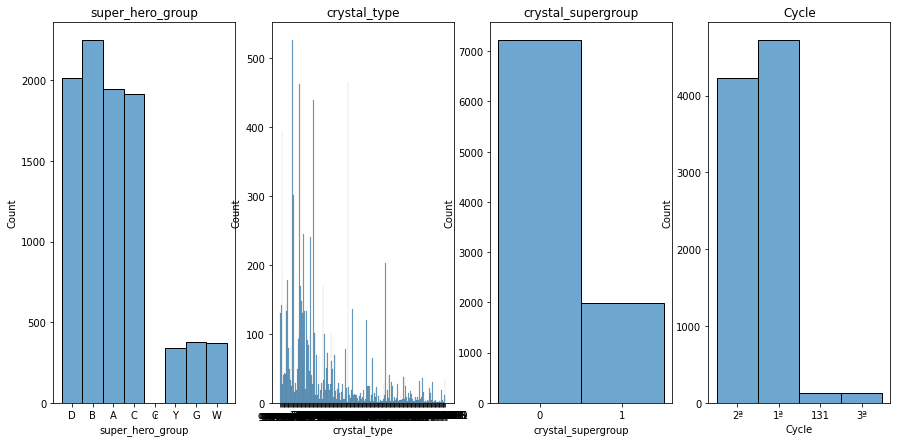

In [18]:
fig, axes = plt.subplots(1, 4, figsize=(15,7))
for idx, col in enumerate(CATEGORICAL_COLUMS):
    sns.histplot(x=col, data=df, ax=axes[idx],  alpha=0.65).set_title(col)

* We need to delete / impute row with the € Character in super_hero_group
* Super_hero_group, crystal_supergroup and Cycle I would suggest to translate to dummy variables
* In Cycle we need to rename values
* cristal type, I suggest to cut the group prefix and only leave the integer

In [19]:
df['super_hero_group'].value_counts()

B    2246
D    2011
A    1943
C    1915
G     378
W     369
Y     340
₢       1
Name: super_hero_group, dtype: int64

* As we want to preserve as much data as possible, we impute instead of deleting 
* In this case we take the value with highest frequence

In [20]:
df.loc[df['super_hero_group'] == '₢', 'super_hero_group'] = 'B'

* Replace non ASCI values in Cycle column

In [21]:
df['Cycle'].value_counts()

1ª     4717
2ª     4226
3ª      134
131     126
Name: Cycle, dtype: int64

In [22]:
df['Cycle'].replace({'1ª':1, '2ª': 2, '3ª':3}, inplace=True)

* Drop 'group' prefix in crystal_type variable

In [23]:
df['crystal_type'].replace({'group ': ''}, regex=True, inplace=True)
# copy crystal_type as int 
df_formated['crystal_type'] = df['crystal_type'].astype(int)

### 7.1.4 Create dummy variables
---

In [24]:
DUMMY_COLUMNS = ['super_hero_group','crystal_supergroup', 'Cycle']

def generate_dummy_features(df_from: pd.DataFrame, df_to: pd.DataFrame, columns_list: list)-> pd.DataFrame:
    '''
    translate categorical variables to dummy variables    
    '''
    
    for col in columns_list:
        df_to =  pd.concat(
            [
                pd.get_dummies(df_from[col], prefix=col, drop_first=True),
                df_to
            ],axis=1
        )
        
    return df_to

df_formated = generate_dummy_features(df, df_formated, DUMMY_COLUMNS)
df_formated.head(5)

,Cycle_2,Cycle_3,Cycle_131,crystal_supergroup_1,super_hero_group_B,super_hero_group_C,super_hero_group_D,super_hero_group_G,super_hero_group_W,super_hero_group_Y,...,predicted_process_end_diff_subprocess1_end,predicted_process_end_diff_reported_on_tower,predicted_process_end_diff_opened,process_end_diff_subprocess1_end,process_end_diff_reported_on_tower,process_end_diff_opened,subprocess1_end_diff_reported_on_tower,subprocess1_end_diff_opened,reported_on_tower_diff_opened,crystal_type
0,1,0,0,0,0,0,1,0,0,0,...,14,4,250815,1,-9,250802,-10,250801,250811,27
1,1,0,0,0,0,0,1,0,0,0,...,11,-4,250943,1,-14,250933,-15,250932,250947,56
2,1,0,0,0,0,0,1,0,0,0,...,13,0,251008,1,-12,250996,-13,250995,251008,56
3,1,0,0,0,0,0,1,0,0,0,...,15,7,0,0,-8,-15,-8,-15,-7,56
4,1,0,0,0,0,0,1,0,0,0,...,36,26,-7,0,-10,-43,-10,-43,-33,27


### 7.1.5 Format numerical columns
---

Insights we gained before:
* crystal_weight has 2.76% nans  -> impute median
* previous_adamantium has 2.87% nans -> impute median
* raw_kryptonite has 47.53 % nans - delete this column ?
* argon has 3.50 % nans and 51 % zeros - are the zeros ok ?
* pure_seastone has 10 % nans - impute median

In [25]:
#fig, axes = plt.subplots(len(NUMERICAL_COLUMNS), 1, figsize=(15,25))
#for  col, ax in zip(NUMERICAL_COLUMNS, axes):
#    sns.histplot(x=col, data=df, ax=ax,  alpha=0.65).set_title(col)


In [26]:
for col in NUMERICAL_COLUMNS:
    # change columnt type to int
    df_formated[col] = df[col]
    # fill nans
    df_formated[col] = df_formated[col].fillna(df_formated[col].median())

#drop raw kryptonite
df_formated.drop('raw_kryptonite', axis=1, inplace=True)

In [27]:
def generate_new_product_features(df: pd.DataFrame, date_columns: list)-> pd.DataFrame:
    '''
    generate new product features
    
    '''

    combination_of_date_columns = list(itertools.combinations(date_columns, 2))

    # compute differences in minutes between ALL datetime columns
    for col1, col2 in combination_of_date_columns:
        column_name = f"{col1}_mull_{col2}" 
        df[column_name] = df[col1].astype(int) * df[col2].astype(int)
        
    return df

#df_formated = generate_new_product_features(df_formated, df_formated.columns.tolist())

In [28]:
df_formated.head(5)

,Cycle_2,Cycle_3,Cycle_131,crystal_supergroup_1,super_hero_group_B,super_hero_group_C,super_hero_group_D,super_hero_group_G,super_hero_group_W,super_hero_group_Y,...,first_factor_x,expected_final_factor_x,final_factor_x,previous_adamantium,Unnamed: 17,chemical_x,argon,pure_seastone,groups,index_predictors
0,1,0,0,0,0,0,1,0,0,0,...,1597.0,1577.0,1578.0,0.0650,1597.0,15.850000,0.0,49.51,0.0,0
1,1,0,0,0,0,0,1,0,0,0,...,1595.0,1565.0,1572.0,0.0309,1595.0,21.966667,0.0,99.94,0.0,1
2,1,0,0,0,0,0,1,0,0,0,...,1608.0,1565.0,1568.0,0.0510,1608.0,21.166667,0.0,91.49,0.0,2
3,1,0,0,0,0,0,1,0,0,0,...,1587.0,1571.0,1576.0,0.0520,1587.0,15.250000,0.0,357.64,0.0,3
4,1,0,0,0,0,0,1,0,0,0,...,1599.0,1579.0,1590.0,0.2800,1599.0,20.566667,0.0,509.19,0.0,4


# 8. Scale predictors
---


In [29]:
# We use standart scaler, zero mean an unit stadart deviation
ss_scaler = StandardScaler()
df_ss = ss_scaler.fit_transform(df_formated)
df_ss = pd.DataFrame(df_ss, columns=df_formated.columns.tolist())

In [30]:
#rs_scaler = preprocessing.RobustScaler()
#df_rs = rs_scaler.fit_transform(df)
#df_rs = pd.DataFrame(df_rs, columns=df.columns.tolist())

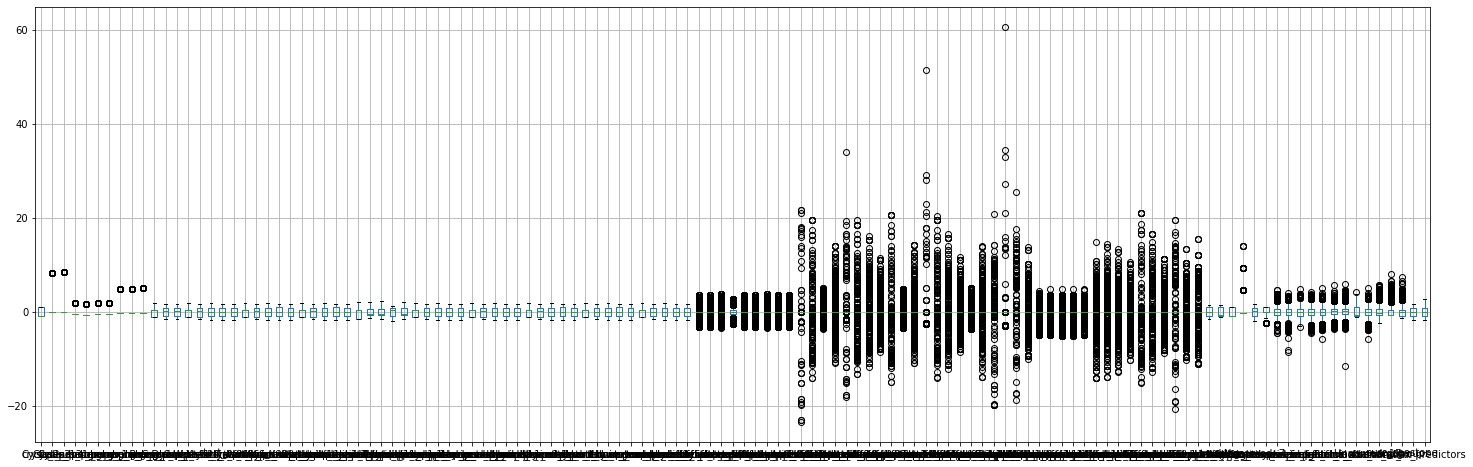

In [31]:
# We check the destributions of our predictors
plt.figure(figsize=(25, 8))
ax = df_ss.boxplot()
#ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

# 9. Filter intra-correlations
---

In [32]:
def filter_intra_correlations(
    df_corr: pd.DataFrame,
    corr_thresshold: float = 0.5,
)-> list:

    corr_cols = []
    for column in df_corr.columns.tolist():
        
        if column not in corr_cols:
            cor_target = abs(df_corr[column])
            cor_features = cor_target[ (cor_target>corr_thresshold) & (cor_target<1 )  ]
            #print(cor_features)
            #print(cor_features.index.tolist())
            corr_cols.extend(cor_features.index.tolist())
            #print(corr_cols)
    
    uncorelated_columns = [ x for x in df_corr.columns.tolist() if x not in  corr_cols ]
    #print(uncorelated_columns)#, corr_cols)
    return uncorelated_columns

## 9.1 Plot correlation map
---

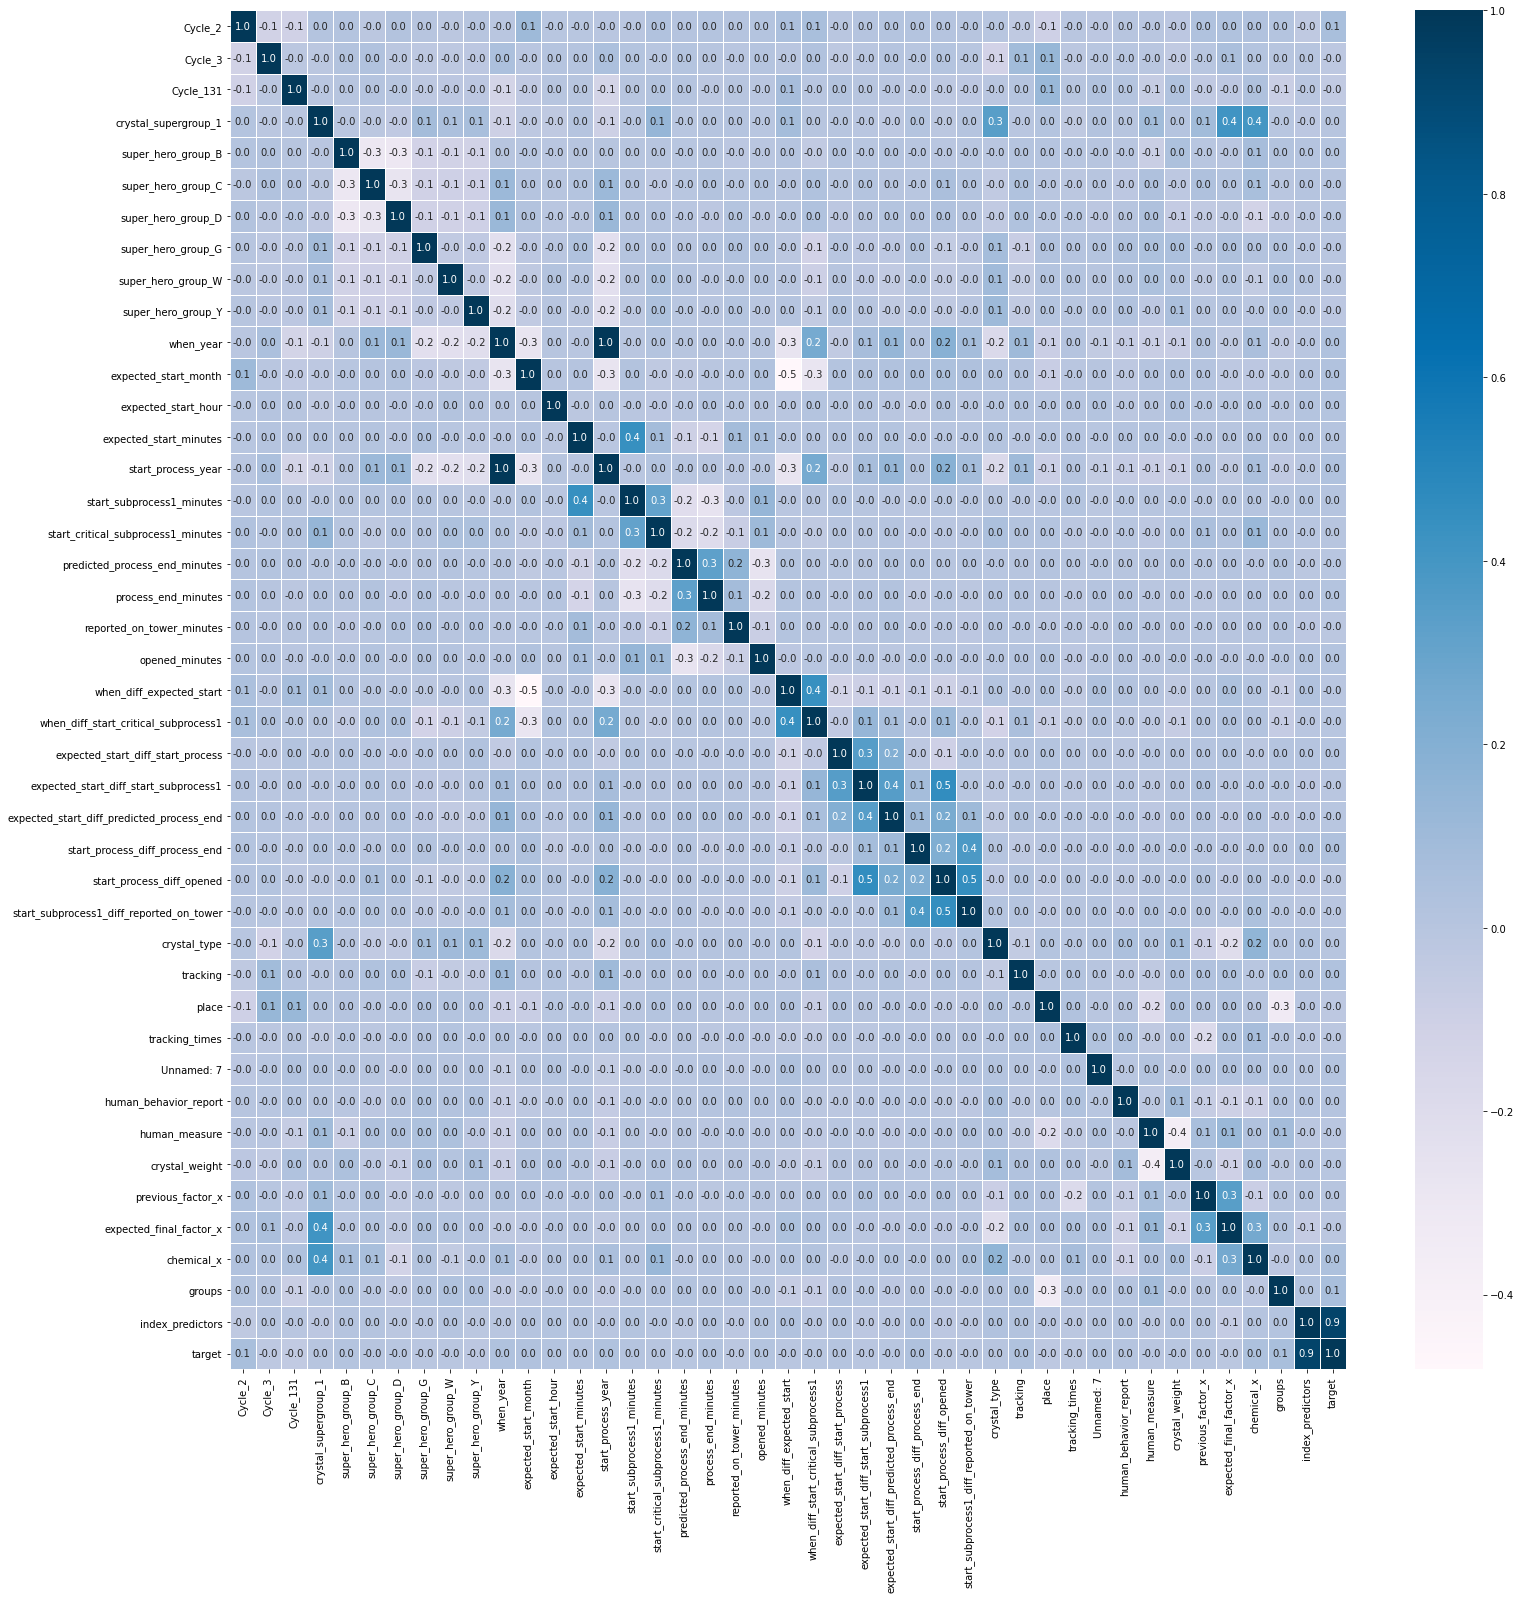

In [33]:
#correlation map
df_corr = df_ss.corr()

# Filter intracorrelated features
UNCORELATED_COLUMNS = filter_intra_correlations(
    df_corr,
    corr_thresshold=0.5
)

# add target to see corelations with our target variable
df_ss = pd.concat(
    [df_ss, df[TARGET_COLUMN].reset_index(drop=True)],
    axis=1,
    #ignore_index=True
)

# compute correlation matrix
df_corr = df_ss[UNCORELATED_COLUMNS + TARGET_COLUMN].corr()

# plot correlation map
plt.subplots(figsize=(25, 25))
sns.heatmap(
    df_corr, 
    annot=True, 
    linewidths=.5, 
    fmt= '.1f',
    cmap=plt.cm.PuBu
)
df_ss.drop(TARGET_COLUMN, axis=1, inplace=True)

What we have:
* The predictor "index_predictors" (former "unknown: 0" variable) has highest impact on target (0.9)
* "Cycle_2" and "groups" predictors have weak (both 0.1) impact on target (in connection with previous statement, we will be able to explain target)
* All other predictors have no influence on target

# 10. Modeling
---
* We will begin now with modeling, Our baseline will be multivariate regression with all predictors
* Then we will just pick up predictors with low p-value and try to analyze the mmodel performance again.
* Finaly stepwise regression analysis will unveil most important predictors (we can compare it with predictors selected by hand)

In [34]:
# split data set in train and test
X_train, X_test, Y_train, Y_test = train_test_split(
    df_ss[UNCORELATED_COLUMNS],
    df[TARGET_COLUMN],
    test_size = 0.1,
    random_state = 123
)

In [35]:
model_ols = sm.OLS(
    Y_train['target'].tolist(),
    X_train
).fit()
model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.235
Model:                            OLS   Adj. R-squared (uncentered):              0.231
Method:                 Least Squares   F-statistic:                              61.63
Date:                Fri, 15 Oct 2021   Prob (F-statistic):                        0.00
Time:                        10:24:54   Log-Likelihood:                         -49843.
No. Observations:                8282   AIC:                                  9.977e+04
Df Residuals:                    8241   BIC:                                  1.001e+05
Df Model:                          41                                                  
Covariance Type:            nonrobust                                                  
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Cycle_2                                       4.6666      1.136      4.107      0.000       2.439       6.894
Cycle_3                                      -2.2022      1.145     -1.923      0.055      -4.448       0.043
Cycle_131                                    -1.5795      1.150     -1.374      0.169      -3.833       0.674
crystal_supergroup_1                          0.8299      1.454      0.571      0.568      -2.021       3.681
super_hero_group_B                            0.3770      1.416      0.266      0.790      -2.399       3.153
super_hero_group_C                           -0.3632      1.383     -0.263      0.793      -3.074       2.348
super_hero_group_D                            0.2389      1.401      0.171      0.865      -2.507       2.984
super_hero_group_G                            0.1993      1.260      0.158      0.874      -2.270       2.668
super_hero_group_W                           -0.1690      1.261     -0.134      0.893      -2.640       2.302
super_hero_group_Y                            0.6957      1.243      0.560      0.576      -1.740       3.131
when_year                                     1.0825      0.902      1.200      0.230      -0.686       2.851
expected_start_month                          0.3558      1.622      0.219      0.826      -2.824       3.536
expected_start_hour                           0.2332      1.098      0.212      0.832      -1.919       2.386
expected_start_minutes                        0.0142      1.233      0.012      0.991      -2.404       2.432
start_process_year                            1.0825      0.902      1.200      0.230      -0.686       2.851
start_subprocess1_minutes                     0.2206      1.317      0.167      0.867      -2.362       2.803
start_critical_subprocess1_minutes            0.4094      1.202      0.340      0.733      -1.947       2.766
predicted_process_end_minutes                 0.9975      1.217      0.819      0.413      -1.389       3.384
process_end_minutes                          -0.0563      1.203     -0.047      0.963      -2.414       2.301
reported_on_tower_minutes                     0.2945      1.122      0.262      0.793      -1.905       2.494
opened_minutes                                0.3059      1.146      0.267      0.790      -1.941       2.553
when_diff_expected_start                     -1.2856      1.838     -0.699      0.484      -4.889       2.318
when_diff_start_critical_subprocess1         -0.1349      1.408     -0.096      0.924      -2.894       2.625
expected_start_diff_start_process             0.1463      1.311      0.112      0.911      -2.423       2.716
expected_start

* R² with all predictors is 0.236  (different formula then in skikit.LinearRegression ?)
* We can delete variables with p > 0.05 (alpha for significancy)

## 10.1 Linear Regression with all predictors
---

In [36]:
model = LinearRegression()

model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

df_metrics = pd.DataFrame()
df_metrics = df_metrics.append(pd.Series(
    {
        'Predictors':len(X_test.columns.tolist()),
        'Test data R²':model.score(X_test, Y_test),
        'Test data MSE': mean_squared_error(Y_test, Y_pred),
    },
     name='All Predictors',
    )
)
df_metrics
df_metrics.index=['All Predictors']
df_metrics

,Predictors,Test data MSE,Test data R²
All Predictors,42.0,370.880318,0.893228


## 10.2  Linear Regression with low p value predictors
---

In [37]:
LOW_P_COLUMNS = ['Cycle_2', 'groups', 'index_predictors']

model_ols = sm.OLS(
    Y_train['target'].tolist(),
    X_train[LOW_P_COLUMNS]
).fit()
model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.232
Model:                            OLS   Adj. R-squared (uncentered):              0.232
Method:                 Least Squares   F-statistic:                              834.6
Date:                Fri, 15 Oct 2021   Prob (F-statistic):                        0.00
Time:                        10:24:54   Log-Likelihood:                         -49856.
No. Observations:                8282   AIC:                                  9.972e+04
Df Residuals:                    8279   BIC:                                  9.974e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Cycle_2              4.8989      1.095      4.474      0.000       2.753       7.045
groups               3.2954      1.092      3.018      0.003       1.155       5.436
index_predictors    54.6582      1.097     49.834      0.000      52.508      56.808
==============================================================================
Omnibus:                     1723.459   Durbin-Watson:                   0.083
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4611.608
Skew:                           1.117   Prob(JB):                         0.00
Kurtosis:                       5.894   Cond. No.                         1.03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
model = LinearRegression()

model.fit(X_train[LOW_P_COLUMNS], Y_train)
Y_pred = model.predict(X_test[LOW_P_COLUMNS])

df_metrics = df_metrics.append(pd.Series(
    {
        'Predictors':len(X_test[LOW_P_COLUMNS].columns.tolist()),
        'Test data R²':model.score(X_test[LOW_P_COLUMNS], Y_test),
        'Test data MSE': mean_squared_error(Y_test, Y_pred)
    },
     name='Low P Predictors',
    )
)
df_metrics

,Predictors,Test data MSE,Test data R²
All Predictors,42.0,370.880318,0.893228
Low P Predictors,3.0,393.196898,0.886803


## 10.3 Stepwise Regression (Sequential feature selection)
---

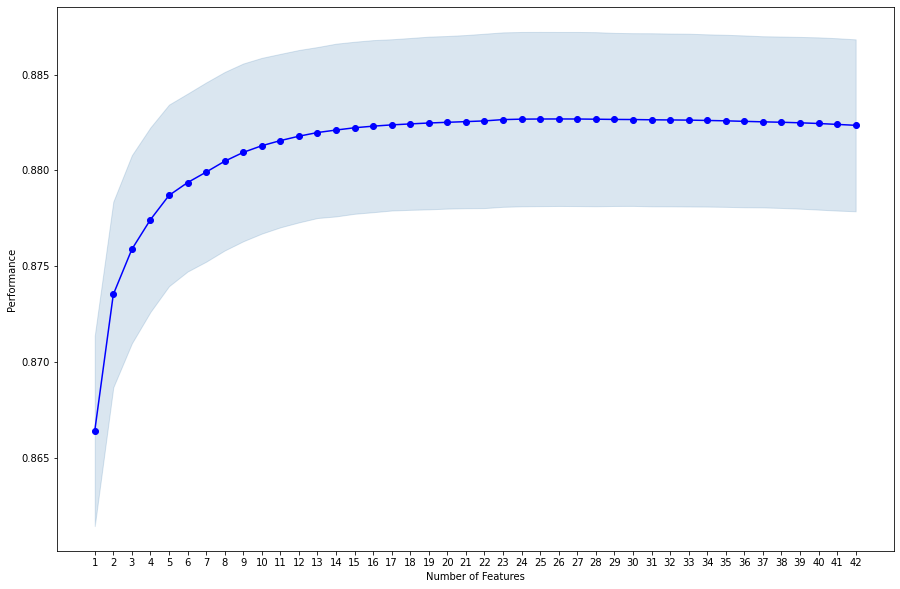

In [39]:
model = LinearRegression()
sfs = SFS(
    model,
    k_features='parsimonious', 
    #verbose=1,
    forward=True, 
    floating=False, 
    scoring='r2',#'neg_mean_squared_error',#'r2',
    cv=10,
    n_jobs=-1,
)
sfs = sfs.fit(X_train, Y_train)
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err', figsize=(15, 10))

* Here we can se how much variation of the target we can explain with certain number of features
* Best predictors according to forward feature selection are the same as selected by hand (Cycle2, groups, index_predictors)
* Using these 3 Predictors we can explain 87% of target variation

In [40]:
pd.DataFrame.from_dict(sfs.get_metric_dict()).T[:10]

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(41,)","[0.858596301346529, 0.8537260622998766, 0.8516...",0.866412,"(index_predictors,)",0.011075,0.014911,0.00497
2,"(0, 41)","[0.866277423773977, 0.8647235783139688, 0.8540...",0.873531,"(Cycle_2, index_predictors)",0.010796,0.014536,0.004845
3,"(0, 40, 41)","[0.8664788211890816, 0.8658006873282414, 0.854...",0.875889,"(Cycle_2, groups, index_predictors)",0.010937,0.014726,0.004909
4,"(0, 10, 40, 41)","[0.8675021119289829, 0.8677341528423116, 0.855...",0.877433,"(Cycle_2, when_year, groups, index_predictors)",0.01073,0.014447,0.004816
5,"(0, 10, 39, 40, 41)","[0.868458793897442, 0.8690934041044777, 0.8555...",0.878699,"(Cycle_2, when_year, chemical_x, groups, index...",0.010556,0.014213,0.004738
6,"(0, 10, 21, 39, 40, 41)","[0.8697353685074956, 0.8696996178891218, 0.856...",0.879368,"(Cycle_2, when_year, when_diff_expected_start,...",0.010344,0.013928,0.004643
7,"(0, 10, 21, 29, 39, 40, 41)","[0.8699938422035802, 0.8695063677972124, 0.856...",0.879916,"(Cycle_2, when_year, when_diff_expected_start,...",0.010421,0.014031,0.004677
8,"(0, 1, 10, 21, 29, 39, 40, 41)","[0.8708099350817892, 0.8699158394660369, 0.857...",0.880483,"(Cycle_2, Cycle_3, when_year, when_diff_expect...",0.010378,0.013973,0.004658
9,"(0, 1, 2, 10, 21, 29, 39, 40, 41)","[0.8713613010625635, 0.8702514898720555, 0.858...",0.880945,"(Cycle_2, Cycle_3, Cycle_131, when_year, when_...",0.010336,0.013917,0.004639
10,"(0, 1, 2, 3, 10, 21, 29, 39, 40, 41)","[0.8719853420989705, 0.8709885003166612, 0.858...",0.881292,"(Cycle_2, Cycle_3, Cycle_131, crystal_supergro...",0.010218,0.013757,0.004586


We take 17  predictors from SFS list

In [41]:
STS17_COLUMNS = ['Cycle_2', 'Cycle_3', 'Cycle_131', 'crystal_supergroup_1', 'super_hero_group_C', 
                 'super_hero_group_D', 'when_year', 'expected_start_month', 'when_diff_expected_start', 
                 'start_process_diff_process_end', 'crystal_type', 'tracking', 'place', 'Unnamed: 7', 
                 'chemical_x', 'groups', 'index_predictors']

In [42]:
model = LinearRegression()

model.fit(X_train[STS17_COLUMNS], Y_train)
Y_pred = model.predict(X_test[STS17_COLUMNS])

df_metrics = df_metrics.append(pd.Series(
    {
        'Predictors':len(X_test[STS17_COLUMNS].columns.tolist()),
        'Test data R²':model.score(X_test[STS17_COLUMNS], Y_test),
        'Test data MSE': mean_squared_error(Y_test, Y_pred)
    },
     name='STS 17 Predictors',
    )
)
df_metrics

,Predictors,Test data MSE,Test data R²
All Predictors,42.0,370.880318,0.893228
Low P Predictors,3.0,393.196898,0.886803
STS 17 Predictors,17.0,370.927563,0.893214


## 10.4 Plot some examples for Test data set 
---
We fit our Regression model with 3 low P predictors

In [43]:
# concat test predictors and test target together
df_test = pd.concat(
    [X_test.reset_index(drop=True), Y_test.reset_index(drop=True)],
    axis=1,
    )


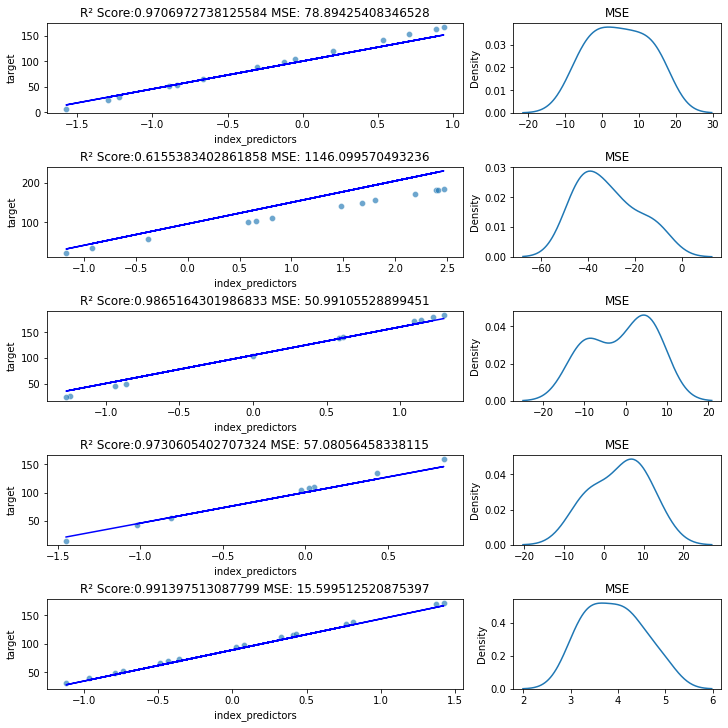

In [44]:
def plot_n_groups(number_groups: int, fit_columns: list)-> None:
    '''
    Plot target points along with predicted regression and MSE dist for n groups
    
    '''

    # take 5 random groups for ploting
    GROUPS_LIST = df_test.sample(number_groups)['groups'].values.tolist()

    # fit on train data
    model = LinearRegression()
    model.fit(X_train[fit_columns], Y_train)

    fig, axes = plt.subplots(number_groups, 2, figsize=(10,10), gridspec_kw={'width_ratios': [2, 1]}, constrained_layout=True )

    for ax, group_idx in zip(axes, GROUPS_LIST):

        # Get dataset of certain group
        df_test_group = df_test[np.isclose(df_test['groups'],  group_idx)][fit_columns + TARGET_COLUMN].reset_index(drop=True)

        # predict on  test
        Y_pred_target = model.predict(df_test_group[fit_columns])

        # real target
        sns.scatterplot(
            x='index_predictors',
            y='target',
            data=df_test_group,
            #color='red',
            ax=ax[0],
            alpha=0.65,
        )
        # reg line
        ax[0].plot(df_test_group['index_predictors'], Y_pred_target, color = "blue")

        # MSE hist
        sns.kdeplot(
            x=df_test_group['target']-Y_pred_target[:,0],
            #color='green',
            ax=ax[1],
            #alpha=0.65,
            #hist=False,
        )
        # title
        ax[1].set_title('MSE')
        ax[1].set_xlabel('')


        # title
        ax[0].set_title( f"R² Score:{ r2_score(df_test_group['target'], Y_pred_target) } MSE: {mean_squared_error(df_test_group['target'], Y_pred_target)}")
        
plot_n_groups(5, LOW_P_COLUMNS)

* Regression line does not fit optimal
* Better Predictors could help
* Maybe interactions of predictors cound improve R²

In [45]:
df_metrics

,Predictors,Test data MSE,Test data R²
All Predictors,42.0,370.880318,0.893228
Low P Predictors,3.0,393.196898,0.886803
STS 17 Predictors,17.0,370.927563,0.893214


Next steps could be:
* create Interactions of predictors (e.g. products)
* try Ridge regression (guess it will point to same predictors like STS)
* try PCA to compress multiple predictors to few.